In [13]:
import pandas as pd
import seaborn as sns
import geopandas
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#print("All libraries imported. ")

In [26]:
from IPython.core.display import HTML
HTML("""
<style>
#top {
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<img src="Images/logo_PID.png" style="width: 70px;"/>

<a id="top"></a>

<!-- &emsp; tab between text -->
 
[Word cloud](#word_cloud) &emsp;
[Total skatepark visitors](#visitors) &emsp;
[Map: Skateparks in Malmö](#map)

#  <center> Welcome to Skateparks in Data result site!</center> 

####  <center> Below you can witness different statistics about the skateparks in Malmö.</center> 
<br><br>

In [28]:
data = "Data/skateparks.csv"
df = pd.read_csv(data)

<a id="word_cloud"></a>

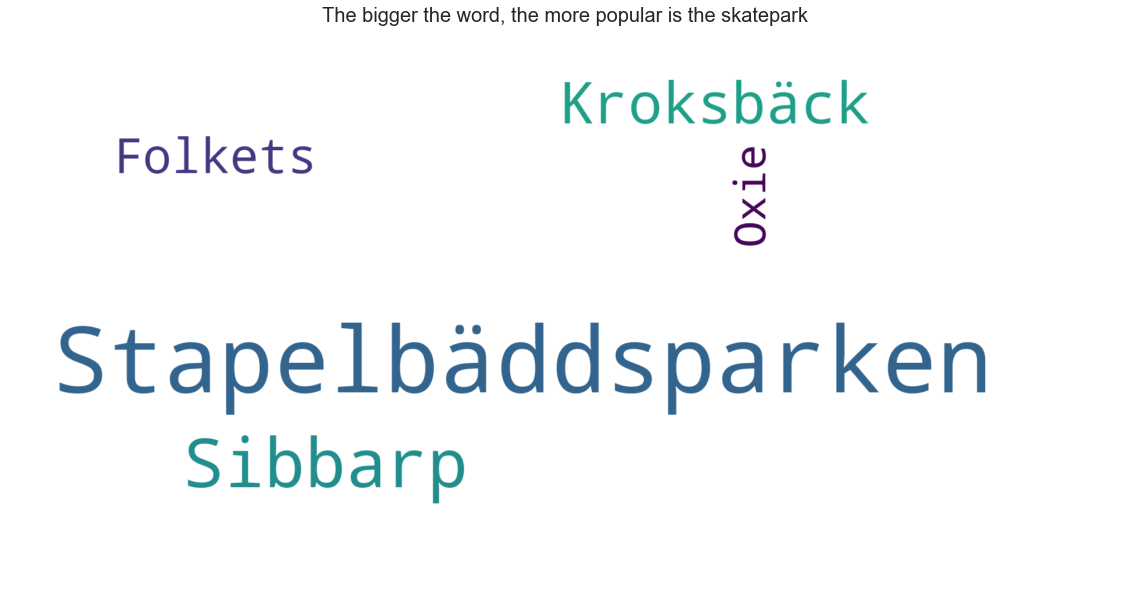

In [16]:
text = df.Skatepark.values
text = " ".join(text)

stopwords = set(STOPWORDS) 
stopwords.update(["skatepark", "park"])

wordcloud = WordCloud(
stopwords = stopwords,
width = 2000,
height = 1000,
collocations=False,
background_color = 'white').generate(str(text))
fig = plt.figure(
figsize = (20, 20))

plt.title('The bigger the word, the more popular is the skatepark', fontsize=20)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

[Top of page](#top)
<br><br><br><br>

<a id="visitors"></a>

# Total visitors
Below you will see total number of visitors in 5 different skateparks in Malmö.

[Top of page](#top)

In [32]:
# Convert object to int
skateparks_to_value = df['Skatepark'].value_counts()
# skateparks_to_value

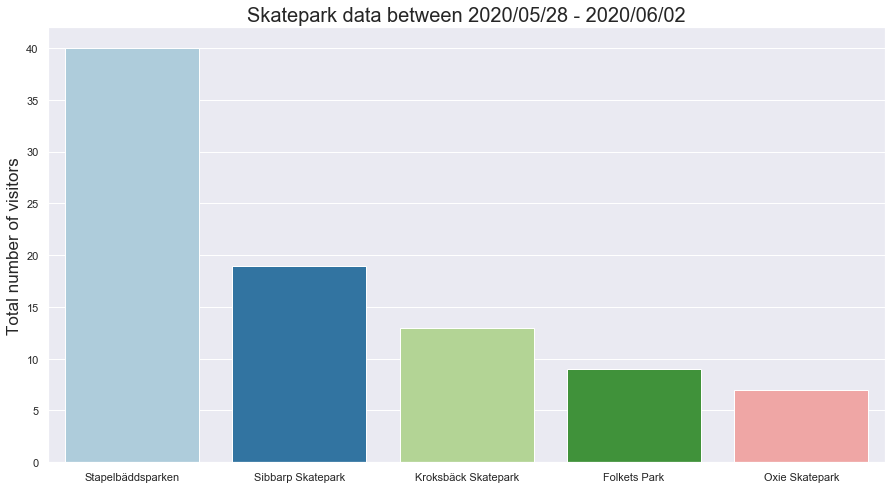

In [33]:
# Create diagram and decide color/size
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
ax = sns.barplot(skateparks_to_value.index, skateparks_to_value.values, palette='Paired')
plt.title('Skatepark data between 2020/05/28 - 2020/06/02', fontsize=20)
plt.ylabel('Total number of visitors', fontsize=17);

<br><br><br><br>

<a id="map"></a>

# **Skateparks in Malmö**
*5 skateparks in Malmö.*

[Top of page](#top)

In [29]:
stapelbäddsparken_coordinates = [55.613781,12.983913]
#stapelbäddsparken_coordinates[1]

In [30]:
# Skatepark coordinates, stored as dictionary

coordinates_dictionary = {
    (55.613781,12.983913): 'Stapelbaddsparken',
    (55.571860, 12.976309): 'Kroksbacks Skatepark',
    (55.5920945, 13.0127095): 'Folkets Park',
    (55.574826, 12.908757): 'Sibbarp Skatepark',
    (55.541088, 13.103231): 'Oxie Skatepark'
}

In [31]:
map = folium.Map(width=1000, location = [55.614709,13.004293], tiles = "OpenStreetMap", zoom_start = 12)

# Looping values with keys with items() method and adding to map
for key, value in coordinates_dictionary.items():
    #print(key, value)
    folium.Marker( key, popup="Skatepark: " + str(value), icon=folium.Icon(color='black', 
                                                                           icon_color='white', 
                                                                           icon='angellist', angle=0, 
                                                                           prefix='fa') ).add_to(map) 
    
# Display map
map